In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.transforms import RandomApply
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import torch.optim as optim
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

Betöltés

- https://www.kaggle.com/datasets/tauilabdelilah/mrl-eye-dataset/data

In [ ]:
data_dir = Path("../train")
subfolders = ["close_eyes", "open_eyes"]

files = []
for label in subfolders:
    folder = data_dir / label
    if not folder.exists():
        print(f"Mappa nem található: {folder}")
        continue
    for file in folder.iterdir():
        if file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            files.append((str(file.resolve()), label))

#random.shuffle(files)

df = pd.DataFrame(files, columns=["filepath", "label"])

print("Összes kép:", len(df))

Összes kép: 81675


Előkészítés

In [4]:
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.RandomHorizontalFlip(p=0.5)
    #transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
    #transforms.ColorJitter(contrast=0.3, brightness=0.2)
])

transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [5]:
class EyesDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label_map = {"close_eyes": 0, "open_eyes": 1}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["filepath"]).convert("L")
        if self.transform:
            img = self.transform(img)
        label = self.label_map[row["label"]]
        return img, label

In [6]:
BATCH = 32

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

train_dataset = EyesDataset(train_df, transform=transform_train)
val_dataset = EyesDataset(val_df, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}")

Train: 65340, Validation: 16335


Model

In [7]:
class EyeCNN(nn.Module):
    def __init__(self):
        super(EyeCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
model = EyeCNN().to(device)

In [8]:
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), 
                       lr=0.00005, 
                       weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.5, 
                                                 patience=3, 
                                                 verbose=True)

In [ ]:
num_epochs = 20

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):

    model.train()

    running_loss = 0.0
    train_preds, train_labels = [], []

    for imgs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):

        imgs = imgs.to(device)
        labels = labels.to(device).float().view(-1, 1)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # paraméterek frissítése

        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        train_preds.extend(preds.cpu().numpy().flatten().tolist())
        train_labels.extend(labels.cpu().numpy().flatten().tolist())

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    acc = accuracy_score(train_labels, train_preds)
    train_accuracies.append(acc)
    print(f"Epoch {epoch+1}: Loss: {avg_loss:.4f}, Training Accuracy: {acc:.4f}")
    

    # Validáció
    model.eval()
    running_val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device).float().view(-1, 1)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_preds.extend(preds.cpu().numpy().flatten().tolist())
            val_labels.extend(labels.cpu().numpy().flatten().tolist())

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)
    print(f"Validation: Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")

    scheduler.step(avg_val_loss) # tanulási ráta frissítése

Training Epoch 1/20: 100%|██████████| 2042/2042 [08:59<00:00,  3.79it/s]  


Epoch 1: Loss: 0.2363, Training Accuracy: 0.9081
Validation: Loss: 0.1505, Accuracy: 0.9459


Training Epoch 2/20: 100%|██████████| 2042/2042 [01:11<00:00, 28.37it/s]


Epoch 2: Loss: 0.1532, Training Accuracy: 0.9452
Validation: Loss: 0.1634, Accuracy: 0.9370


Training Epoch 3/20: 100%|██████████| 2042/2042 [01:12<00:00, 28.34it/s]


Epoch 3: Loss: 0.1317, Training Accuracy: 0.9542
Validation: Loss: 0.1189, Accuracy: 0.9566


Training Epoch 4/20: 100%|██████████| 2042/2042 [01:12<00:00, 28.30it/s]


Epoch 4: Loss: 0.1183, Training Accuracy: 0.9578
Validation: Loss: 0.0989, Accuracy: 0.9653


Training Epoch 5/20: 100%|██████████| 2042/2042 [01:12<00:00, 28.32it/s]


Epoch 5: Loss: 0.1100, Training Accuracy: 0.9606
Validation: Loss: 0.0895, Accuracy: 0.9685


Training Epoch 6/20: 100%|██████████| 2042/2042 [01:12<00:00, 28.24it/s]


Epoch 6: Loss: 0.1006, Training Accuracy: 0.9643
Validation: Loss: 0.0874, Accuracy: 0.9691


Training Epoch 7/20: 100%|██████████| 2042/2042 [01:11<00:00, 28.36it/s]


Epoch 7: Loss: 0.0951, Training Accuracy: 0.9666
Validation: Loss: 0.0786, Accuracy: 0.9712


Training Epoch 8/20: 100%|██████████| 2042/2042 [01:12<00:00, 28.26it/s]


Epoch 8: Loss: 0.0894, Training Accuracy: 0.9685
Validation: Loss: 0.0751, Accuracy: 0.9728


Training Epoch 9/20: 100%|██████████| 2042/2042 [01:13<00:00, 27.97it/s]


Epoch 9: Loss: 0.0838, Training Accuracy: 0.9705
Validation: Loss: 0.0683, Accuracy: 0.9748


Training Epoch 10/20: 100%|██████████| 2042/2042 [01:12<00:00, 28.21it/s]


Epoch 10: Loss: 0.0792, Training Accuracy: 0.9724
Validation: Loss: 0.0636, Accuracy: 0.9759


Training Epoch 11/20: 100%|██████████| 2042/2042 [01:10<00:00, 28.93it/s]


Epoch 11: Loss: 0.0729, Training Accuracy: 0.9748
Validation: Loss: 0.0629, Accuracy: 0.9778


Training Epoch 12/20: 100%|██████████| 2042/2042 [01:11<00:00, 28.55it/s]


Epoch 12: Loss: 0.0688, Training Accuracy: 0.9759
Validation: Loss: 0.0544, Accuracy: 0.9799


Training Epoch 13/20: 100%|██████████| 2042/2042 [01:12<00:00, 28.03it/s]


Epoch 13: Loss: 0.0654, Training Accuracy: 0.9770
Validation: Loss: 0.0558, Accuracy: 0.9811


Training Epoch 14/20: 100%|██████████| 2042/2042 [01:12<00:00, 28.10it/s]


Epoch 14: Loss: 0.0607, Training Accuracy: 0.9783
Validation: Loss: 0.0523, Accuracy: 0.9814


Training Epoch 15/20: 100%|██████████| 2042/2042 [01:12<00:00, 28.29it/s]


Epoch 15: Loss: 0.0580, Training Accuracy: 0.9794
Validation: Loss: 0.0489, Accuracy: 0.9830


Training Epoch 16/20: 100%|██████████| 2042/2042 [01:12<00:00, 28.32it/s]


Epoch 16: Loss: 0.0557, Training Accuracy: 0.9800
Validation: Loss: 0.0481, Accuracy: 0.9833


Training Epoch 17/20: 100%|██████████| 2042/2042 [01:12<00:00, 28.18it/s]


Epoch 17: Loss: 0.0547, Training Accuracy: 0.9813
Validation: Loss: 0.0523, Accuracy: 0.9811


Training Epoch 18/20: 100%|██████████| 2042/2042 [01:11<00:00, 28.37it/s]


Epoch 18: Loss: 0.0504, Training Accuracy: 0.9822
Validation: Loss: 0.0493, Accuracy: 0.9821


Training Epoch 19/20: 100%|██████████| 2042/2042 [01:12<00:00, 28.25it/s]


Epoch 19: Loss: 0.0496, Training Accuracy: 0.9826
Validation: Loss: 0.0454, Accuracy: 0.9840


Training Epoch 20/20: 100%|██████████| 2042/2042 [01:08<00:00, 29.87it/s]


Epoch 20: Loss: 0.0485, Training Accuracy: 0.9834
Validation: Loss: 0.0484, Accuracy: 0.9832


In [12]:
val_precision = precision_score(val_labels, val_preds, zero_division=0)
val_recall = recall_score(val_labels, val_preds, zero_division=0)
val_f1 = f1_score(val_labels, val_preds, zero_division=0)

print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-score: {val_f1:.4f}")

Precision: 0.9868
Recall: 0.9799
F1-score: 0.9834


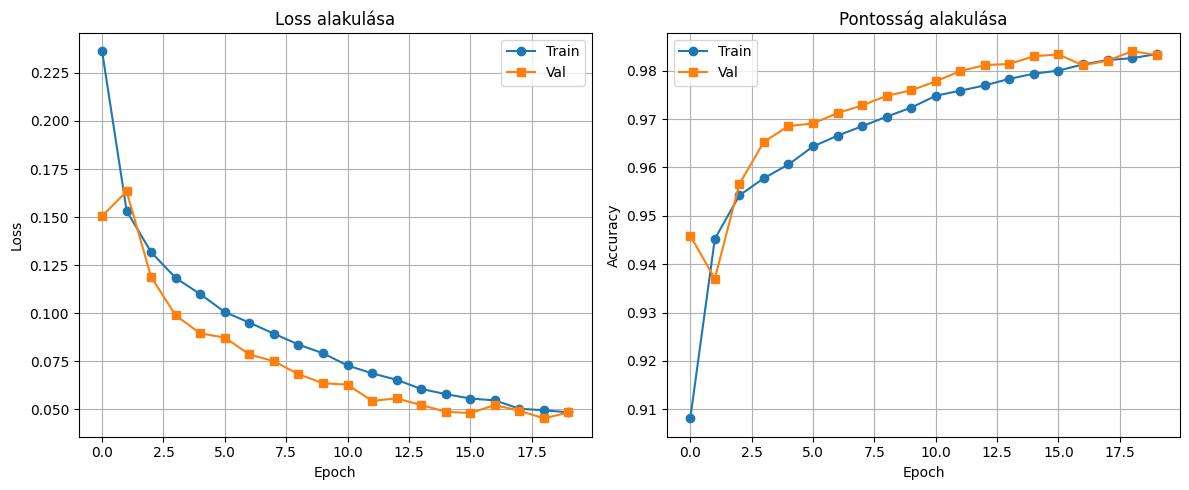

In [ ]:
epochs_range = range(num_epochs)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label="Train", marker="o")
plt.plot(epochs_range, val_losses, label="Val", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss alakulása")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs_range, train_accuracies, label="Train", marker="o")
plt.plot(epochs_range, val_accuracies, label="Val", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Pontosság alakulása")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Test

In [ ]:
test_data_dir = Path("../test")
test_subfolders = ["close_eyes", "open_eyes"]

test_files = []
for label in test_subfolders:
    folder = test_data_dir / label
    if not folder.exists():
        print(f"Mappa nem található: {folder}")
        continue
    for file in folder.iterdir():
        if file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            test_files.append((str(file.resolve()), label))

test_df = pd.DataFrame(test_files, columns=["filepath", "label"])
print("Összes test kép:", len(test_df))

Összes test kép: 3223


In [15]:
test_dataset = EyesDataset(test_df, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

In [17]:
model.eval()
running_test_loss = 0.0
test_preds, test_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device).float().view(-1, 1)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        test_preds.extend(preds.cpu().numpy().flatten().tolist())
        test_labels.extend(labels.cpu().numpy().flatten().tolist())

avg_test_loss = running_test_loss / len(test_loader)
test_acc = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, zero_division=0)
test_recall = recall_score(test_labels, test_preds, zero_division=0)
test_f1 = f1_score(test_labels, test_preds, zero_division=0)

print(f"Test: Loss: {avg_test_loss:.4f}, Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_f1:.4f}")

Test: Loss: 0.2589, Accuracy: 0.9091
Precision: 0.9971
Recall: 0.8256
F1-score: 0.9033


Mentés

In [15]:
torch.save(model.state_dict(), "test3cnn.pth")
print("modell mentve")

modell mentve
